# LineIntegralConvolution.jl

Line Integral Convolution (LIC) visualization tool for vector fields

## Usage

In [311]:
using Random
using Plots

### Electrostatic Simulation 

#### Parameters

In [312]:
## image parameters
pt_per_meter = 20  # resolution, number of pixels per meter

x_min = -10
x_max = 10

y_min = 3
y_max = 9

n_charges = 12  # number of charges to simulate

charge_value = 1e-6  # electric charge value (C)

distribution = "circle"  # "circle", "random"

SEED = 1

1

#### Constants

For electric (E) field computation

In [313]:
epsilon_zero = 8.85e-12  # empty space dielectric constant
k = 1.0 / (4.0 * pi * epsilon_zero)  # constant, see electric field generated form a point source

8.991804694457363e9

#### Utils

In [314]:
function meshgrid(xin, yin)
    nx = length(xin)
    ny = length(yin)
    xout = zeros(ny, nx)
    yout = zeros(ny, nx)
    for jx = 1:nx
        for ix = 1:ny
            xout[ix, jx] = xin[jx]
            yout[ix, jx] = yin[ix]
        end
    end
    return (x=xout, y=yout)
end

meshgrid (generic function with 1 method)

#### Simulation

Compute the 2D electric field of equally charged 'point' sources printosed in a 2D plane


In [315]:
c_seed = SEED  # initialize SEED

step_m = 1.0 / pt_per_meter

pts_x = x_min : step_m : x_max
pts_y = y_min : step_m : y_max

# num_x_points = (x_max - x_min) * pt_per_meter + 1  # +1 to include both ends
# num_y_points = (y_max - y_min) * pt_per_meter + 1  # +1 to include both ends
num_x_points = length(pts_x)
num_y_points = length(pts_y)

points = meshgrid(pts_x, pts_y)
# points.x
# points.y

field_lin = zeros(num_y_points, num_x_points, 2)  # initialize zero electric field 
field_modulus = zeros(num_y_points, num_x_points)  # initialize the modulus only image

if distribution == "random"
    # generate a random position [x, y] for the new charges
    # the code below forces the position to be 'in the center'
    charge_x = rand(MersenneTwister(c_seed), Float64, n_charges) * (x_max-x_min) .+ x_min
    c_seed += 1
    charge_y = rand(MersenneTwister(c_seed), Float64, n_charges) * (y_max-y_min) .+ y_min
    c_seed += 1
    charge_q = rand(MersenneTwister(c_seed), (-1, 1), n_charges) .* charge_value
    c_seed += 1
elseif distribution == "circle"
    if n_charges > 1
        angles = 0.0 : 2.0pi / n_charges : 1.999pi
        c_cos = cos.(angles)
        c_sin = sin.(angles)
    else
        c_cos = 0.0
        c_sin = 0.0
    end
    charge_x = x_min + (x_max-x_min) / 2 .+ c_cos * (x_max-x_min) / 4 .+ rand(MersenneTwister(c_seed), Float64) * step_m / 100
    charge_y = y_min + (y_max-y_min) / 2 .+ c_sin * (y_max-y_min) / 4 .+ rand(MersenneTwister(c_seed), Float64) * step_m / 100
    charge_q = ones(n_charges) * charge_value
else
    error("Not implemented!")
end

12-element Vector{Float64}:
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6

In [316]:
for i = 1 : n_charges  # for each electric charge
    # for each pixel of the image, compute the electric field in that point
    # relatively to the currently generated charge
 
    # compute the distance of the current pixel position with
    # respect to the charge position, scaling to make them 'physical'
    dist_x = points.x .- charge_x[i]
    dist_y = points.y .- charge_y[i]
    # compute the squared linear distance between source and pixel
    dist2 = dist_x .^ 2 .+ dist_y .^ 2

    # compute the electric field value for the current pixel
    values = (k * charge_value) ./ dist2
    
    field_modulus .+= abs.(values)

    den = abs.(dist_x) .+ abs.(dist_y)
    x_versor = dist_x ./ den
    y_versor = dist_y ./ den

    # add the field computed to the overall field in this point 
    # (superposition principle)
    field_lin[:, :, 1] .+= values .* x_versor
    field_lin[:, :, 2] .+= values .* y_versor
end

field_log = 10.0*log10.(field_modulus)

121×401 Matrix{Float64}:
 31.3539  31.4056  31.4575  31.5097  …  31.5099  31.4577  31.4058  31.3542
 31.3769  31.4289  31.4811  31.5337     31.5339  31.4814  31.4291  31.3772
 31.3997  31.452   31.5046  31.5575     31.5577  31.5048  31.4522  31.3999
 31.4222  31.4749  31.5278  31.581      31.5813  31.528   31.4751  31.4225
 31.4446  31.4975  31.5508  31.6043     31.6046  31.551   31.4978  31.4448
 31.4666  31.5199  31.5735  31.6274  …  31.6277  31.5738  31.5202  31.4669
 31.4885  31.5421  31.596   31.6503     31.6505  31.5963  31.5423  31.4887
 31.5101  31.564   31.6183  31.6729     31.6731  31.6185  31.5643  31.5103
 31.5314  31.5857  31.6402  31.6952     31.6954  31.6405  31.5859  31.5317
 31.5525  31.6071  31.662   31.7172     31.7175  31.6622  31.6073  31.5527
  ⋮                                  ⋱                              ⋮
 31.5315  31.5858  31.6403  31.6953     31.6955  31.6406  31.586   31.5318
 31.5102  31.5641  31.6184  31.673      31.6732  31.6186  31.5644  31.5104
 31.4

#### Figures

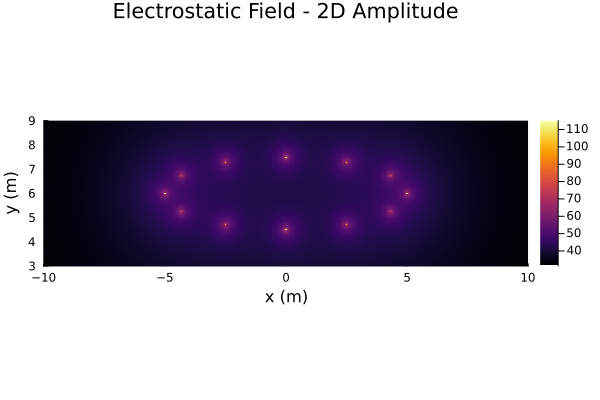

In [317]:
heatmap(
    pts_x,
    pts_y,
    field_log, 
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max)
)
title!("Electrostatic Field - 2D Amplitude")
xlabel!("x (m)")
ylabel!("y (m)")
# TODO colorbar label is missing

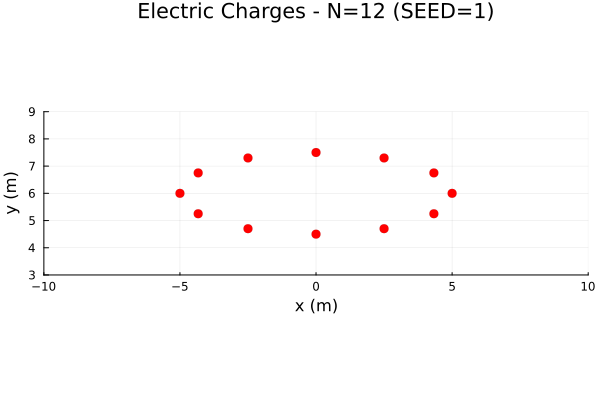

In [318]:
scatter(
    [charge_x], 
    [charge_y],
    zcolor=charge_q,
    legend=false, 
    markerstrokewidth=0, 
    marker=:circle, 
    markersize=5.0, 
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    c=:rainbow
)
title!("Electric Charges - N=$n_charges (SEED=$SEED)")
xlabel!("x (m)")
ylabel!("y (m)")

### LIC

#### Parameters

In [319]:
SEED = 7  # Random Seed

struct Field2D
    pos_x
    pos_y
    val_x
    val_y
end

e_field = Field2D(
    pts_x, 
    pts_y,
    field_lin[:, :, 1],
    field_lin[:, :, 2]
)

kernel_size = 30
kernel_lpf = ones(kernel_size) / kernel_size

kernel_cos = cos.(0.0 : pi / (2.0* kernel_size) : pi/2.0)
kernel_cos = kernel_cos / sum(kernel_cos)

kernel = kernel_cos

31-element Vector{Float64}:
 0.051035433285120224
 0.0509654909975177
 0.05075585584165883
 0.05040710241293426
 0.04992018662025056
 0.04929644306595037
 0.04853758138776017
 0.047645681572792024
 0.046623188256443585
 0.04547290402182231
 ⋮
 0.020757980812308768
 0.01828946358054451
 0.015770816200391002
 0.013208942109248232
 0.010610863225926307
 0.007983700704054178
 0.00533465541349248
 0.0026709882032497382
 3.125019000786039e-18

#### Initialization

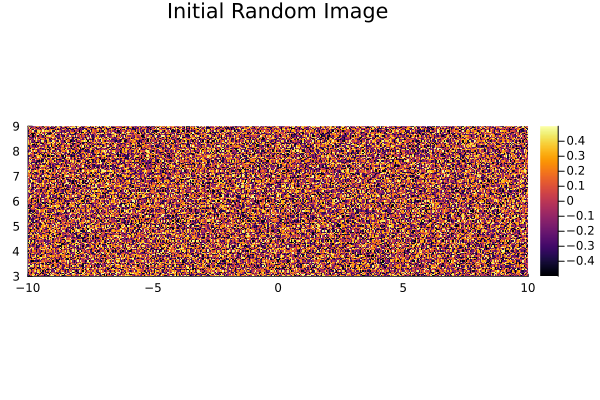

In [320]:
image_width = length(e_field.pos_y)
image_height = length(e_field.pos_x)

## initial random image
random_image = rand(MersenneTwister(c_seed), image_width, image_height) .- 0.5
c_seed += 1

# new images
img = zeros(length(e_field.pos_y), length(e_field.pos_x))

heatmap(
    pts_x,
    pts_y,
    random_image, 
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max)
)
title!("Initial Random Image")

In [321]:
# compute LIC

theta_mat = atan.(field_lin[:, :, 1], field_lin[:, :, 2])
Δx = sin.(theta_mat)
Δy = cos.(theta_mat)
abs_sin = abs.(Δx)
abs_cos = abs.(Δy)

target_num_prints = 10

for x = 1 : image_width
    for y = 1 : image_height

        if rand() > 1.0 - target_num_prints / (image_width * image_height)
            print((((x * (image_height-1) + y)/(image_width * image_height))*100), " %\n");
        end

        c_pix = random_image[x, y] * kernel[1]
        xp = x
        yp = y
        cdx = 0
        cdy = 0
        for w = 2 : kernel_size

            cdx += Δx[xp, yp]
            cdy += Δy[xp, yp]

            # compute new position pixel
            xpc = x + Int(round(cdx))
            ypc = y + Int(round(cdy))

            # check new position is valid
            if xpc < 1
                xpc = 1
            elseif xpc > image_width
                xpc = image_width
            end
            if ypc < 1
                ypc = 1
            elseif ypc > image_height
                ypc = image_height
            end

            # interpolate

            c_pix += random_image[xpc, ypc] * kernel[w]

            # norm_factor = (1 - abs_cos[xp, yp]) * (1 - abs_sin[xp, yp])
            # c_pix += random_image[xp, yp] * kernel[w] * norm_factor

            # norm_factor = abs_cos[xp, yp]
            # c_pix += random_image[xpc, yp] * kernel[w] * norm_factor

            # norm_factor = abs_sin[xp, yp]
            # c_pix += random_image[xp, ypc] * kernel[w] * norm_factor
            
            # norm_factor = abs_cos[xp, yp] * abs_sin[xp, yp]
            # c_pix += random_image[xpc, ypc] * kernel[w] * norm_factor

            xp = xpc
            yp = ypc
        end
        
        # new_image[x, y, 1] = (current_pixel2 + .5) * 0.5 + (field_log[x, y]) * 0.5
        # new_image[x, y, 2] = (current_pixel2 + .5) * 0.5 + (field_log[x, y]) * 0.5 
        # new_image[x, y, 3] = (current_pixel2 + .5) * 0.5 + (1 - field_log[x, y]) * 0.5

        img[x, y] = c_pix
    end
end

8.464376249458997 %
8.827105789245895 %
10.762350322540755 %


27.50561612497681 %


54.93703757136086 %
60.65414974959295 %


69.80276581274087 %
75.14890459800911 %


85.14869850167969 %
85.63302487582696 %
87.2941612909874 %
90.74215288225716 %
91.85095113456029 %


#### Figures

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/davide/.julia/packages/Plots/p3KMq/src/backends/gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/davide/.julia/packages/Plots/p3KMq/src/backends/gr.jl:528


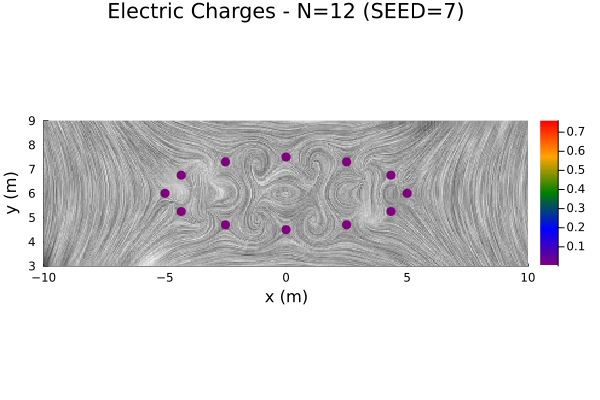

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/davide/.julia/packages/Plots/p3KMq/src/backends/gr.jl:528


In [322]:
heatmap(
    pts_x,
    pts_y,
    img .+ 0.5,
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    c=:grays
)
title!("LIC (LPF)")
scatter!(
    [charge_x], 
    [charge_y],
    zcolor=charge_q,
    legend=false, 
    markerstrokewidth=0, 
    marker=:circle, 
    markersize=5.0, 
    aspect_ratio=:equal,
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    c=:rainbow
)
title!("Electric Charges - N=$n_charges (SEED=$SEED)")
xlabel!("x (m)")
ylabel!("y (m)")

In [323]:
savefig("myplot.pdf")

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /Users/davide/.julia/packages/Plots/p3KMq/src/backends/gr.jl:528


"/Users/davide/Documents/SW Projects/LineIntegralConvolution.jl/myplot.pdf"